In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gym
import numpy as np
import os
import ptan

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections

import seaborn as sns

sns.set_style('darkgrid')

In [2]:
X = ((6*10**6)**3/(6.674*10**(-11)*6*10**(24)))**0.5
MS = 5000
print('seconds per step: ', (2*np.pi*2**1.5)*X/MS)

seconds per step:  2.6104357394519746


## Solving the System of Equations

$\ddot{r} = r \dot{\theta}^2 - \frac{1}{r^2}$

$\ddot{\theta} = -2 \frac{\dot{r}}{r} \dot{\theta}$ 

### System of Equations

$y_0 = r$

$y_1 = \dot{r}$

$y_2 = \theta$

$y_3 = \dot{\theta}$

---


$\dot{y}_0 = y_1$

$\dot{y}_1 = y_0 y_3^2 - \frac{1}{y_0^2}$

$\dot{y}_2 = y_3$

$\dot{y}_3 = -2 \frac{y_1}{y_0} y_3$ 

### RK4 Algorithm


In [172]:
class OrbitalDynamicsEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    # dt_s -- is the time step in seconds.
    def __init__(self, planet_Mass_kg = 5.972*10**(24), planet_R_km = 6371.0, 
                 dt_s = 1.0, target_alt = 2.0, thrust_gs= 1.5, verbose = False, 
                 record_history = True, record_rate = 100):
        super(OrbitalDynamicsEnv, self).__init__()
        self.record_rate = record_rate
    
        # Actions
        self.action_space = gym.spaces.Box(low=np.array([0, 0]), 
                                           high=np.array([2*np.pi, 10**3]), 
                                           dtype=np.float32)
        
        # Obs (r,rdot,theta,theta_dot)
        self.observation_space = gym.spaces.Box(low=np.array([0,0,0,0]), 
                                                high=np.array([10**9,10**9,2*np.pi,10**9]), 
                                                dtype=np.float64)
        
        
        self.record_history = record_history
        
        # Newton's Gravitational Constant in SI units
        G = 6.674*10**(-11) # m^3 kg^-1 s^-2 
        
        # Convert to Natural Problem Units
        # tn_s = (R^3/GM)^1/2 -- where all measures are in SI units
        planet_R_m = planet_R_km*10**3
        tn_s = (planet_R_m**3/(G*planet_Mass_kg))**0.5
        
        # define the time step in seconds
        self.dts = dt_s
        # define the natural length in meters
        self.ln_m = planet_R_m
        # convert the time step in seconds to natural time
        self.dt = dt_s/tn_s
        
        if verbose:
            print('Units')
            print('-----')
            print('\ttime: 1 s = ', 1.0/tn_s,' tn')
            print('\tlength: 1 m = ',1.0/planet_R_m,' ln')
            print('Simulation parameters')
            print('-----')
            print('\tnatural units time step size: ',self.dt)
        
        # setting the target altitude in natural units
        self.target_alt = target_alt
        
        # solving the oribital angular velocity in natural units
        self.oribit_theta_dot = target_alt**(-1.5)
        
        # solving the maxium allowable natural time to run an episode
        self.max_time = 2*np.pi*target_alt**(1.5)
        # adding in a buffer to allow it to go a little longer
        self.max_time = self.max_time*1.5
        # solving the maximum allowable steps given the max time
        self.max_steps = np.int32(np.ceil(self.max_time/self.dt))
        
        if verbose:
            print('\ttarget theta dot: ', self.oribit_theta_dot, ' 1/tn')
            print('\tmax allowable natural time: ', self.max_time, " tn = ", self.max_time*tn_s," s")
            print('\tmax allowed steps: ', self.max_steps)
        
        # Choosing how strong the penalty factors will be for taking actions
        self.orientation_penalty = 0.1
        self.thrust_penalty = 10*self.orientation_penalty
        
        # max accleration from thrust in natural units (ln/tn^2)
        # 1 g = GM/R_planet^2 --in natural units--> 1 g= (ln^3/tn^2)/(ln^2)
        # 1 g. = 1 ln/tn^2
        self.max_thrust = thrust_gs
        self.max_o_thrust = 1.0
        
        if verbose:
            print('Policy Parameters')
            print('-----')
            max_thrust_SI = self.max_thrust*(self.ln_m)/(tn_s**2)
            # as a reference https://www.nasa.gov/pdf/466711main_AP_ST_ShuttleAscent.pdf
            # says the spaceshuttle never exceeded 3gs or ~ 30 m/s^2
            print('\tDiscrete thrust acceleration: ', self.max_thrust,' ln/tn^2 = ', max_thrust_SI,' m/s^2')
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.steps = 0
        
        # Orientation Coordinate in global coordinates
        self.orientation_rate = 0.0
        self.orientation_angle = 0.01
        
        # Translational Coordinates
        self.r = 1.0
        self.r_dot = 0.0
        self.r_double_dot = 0.0
        
        self.theta = 0.0
        self.theta_dot = 0.0 # can change this if u want to add planetary rotation
        self.theta_double_dot = 0.0
        
        self.elapsed_time = 0.0 # elapsed sim time in natural units
        self.elapsed_time_s = 0.0 # elapsed sim time in seconds
        
        # initialize the history array
        if self.record_history:
            self.trajectory = np.array([[self.r*np.cos(self.theta), self.r*np.sin(self.theta), self.orientation_angle]])
        
        obs = np.array([self.r,self.r_dot,self.theta,self.theta_dot])
        
        # start off with an impulse to get off the ground
        #obs, reward, done, _ = self.step(2)
        
        return obs
    
    # continous actions = (mean thrust, mean counter clockwise rotation thrust)
    def step(self, action):
        self.steps += 1
        
        # actions segragation
        thrust = np.clip(action[0], 0.0, self.max_thrust)
        orientation_thrust = np.clip(action[1], -self.max_o_thrust, self.max_o_thrust)
        
        self.orientation_angle += self.orientation_rate*self.dt + 0.5*orientation_thrust*self.dt**2
        self.orientation_rate += orientation_thrust*self.dt 
        
        # Translating the actions into the planet centric coordinate system
        action_vector = thrust*np.array([np.cos(self.orientation_angle), 
                                         np.sin(self.orientation_angle)])
        
        #print('action v: ', action_vector)
        
        # current r hat vector and theta hat vector
        r_vect = np.array([np.cos(self.theta), np.sin(self.theta)])
        theta_vect = np.array([-np.sin(self.theta), np.cos(self.theta)])
        
        # projection of actions along r and theta 
        action_along_r = np.dot(r_vect, action_vector)
        action_along_theta = np.dot(theta_vect, action_vector)
        
        #print('r_vect: ', r_vect)
        #print(action_along_r)
        # Execute one time step within the environment using RK4
        self.elapsed_time += self.dt
        self.elapsed_time_s += self.dts

        # integrate
        y0_k1 = self.r_dot
        y1_k1 = self.r*self.r_dot**2 - 1./self.r**2 + action_along_r
        y2_k1 = self.theta_dot
        y3_k1 = -2.0*self.r_dot/self.r*self.theta_dot + action_along_theta
        
        y0_k2 = (self.r_dot + y1_k1*self.dt/2)
        y1_k2 = (self.r + y0_k1*self.dt/2)*(self.r_dot + y1_k1*self.dt/2)**2 - 1./(self.r + y0_k1*self.dt/2)**2 + action_along_r
        y2_k2 = (self.theta_dot + y3_k1*self.dt/2)
        y3_k2 = -2.0*(self.r_dot + y1_k1*self.dt/2)/(self.r + y0_k1*self.dt/2)*(self.theta_dot + y3_k1*self.dt/2) + action_along_theta
        
        y0_k3 = (self.r_dot + y1_k2*self.dt/2)
        y1_k3 = (self.r + y0_k2*self.dt/2)*(self.r_dot + y1_k2*self.dt/2)**2 - 1./(self.r + y0_k2*self.dt/2)**2 + action_along_r
        y2_k3 = (self.theta_dot + y3_k1*self.dt/2)
        y3_k3 = -2.0*(self.r_dot + y1_k2*self.dt/2)/(self.r + y0_k2*self.dt/2)*(self.theta_dot + y3_k2*self.dt/2) + action_along_theta
        
        y0_k4 = (self.r_dot + y1_k3*self.dt)
        y1_k4 = (self.r + y0_k3*self.dt)*(self.r_dot + y1_k3*self.dt)**2 - 1./(self.r + y0_k3*self.dt)**2 + action_along_r
        y2_k4 = (self.theta_dot + y3_k1*self.dt/2)
        y3_k4 = -2.0*(self.r_dot + y1_k2*self.dt/2)/(self.r + y0_k2*self.dt/2)*(self.theta_dot + y3_k2*self.dt) + action_along_theta
        
        
        # Update 
        self.r = self.r + self.dt/6*(y0_k1 + 2*y0_k2 + 2*y0_k3 + y0_k4)
        self.r_dot = self.r_dot + self.dt/6*(y1_k1 + 2*y1_k2 + 2*y1_k3 + y0_k4)

        self.theta = self.theta + self.dt/6*(y2_k1 + 2*y2_k2 + 2*y2_k3 + y2_k4)
        self.theta_dot = self.theta_dot + self.dt/6*(y3_k1 + 2*y3_k2 + 2*y3_k3 + y3_k4)
        
        # prepare to output
        obs = np.array([self.r,self.r_dot,self.theta,self.theta_dot])
        
        # If recording is enabled record the trajectory
        if (self.record_history) and (self.steps % self.record_rate == 0):
            self.trajectory = np.append(self.trajectory, 
                                        [[self.r*np.cos(self.theta), 
                                          self.r*np.sin(self.theta), 
                                          self.orientation_angle]], 
                                        axis=0)
        
        # reward 1 for every step not done, encouraging orbit seeking
        # penalty for every step not near the target altitude
        reward = (1.0 + 
                  - 0.001*thrust/self.max_thrust 
                  - 0.0001*np.abs(orientation_thrust)/self.max_o_thrust -
                  0.01*np.abs(self.target_alt - self.r)/self.target_alt - 
                  0.01*np.abs(self.oribit_theta_dot - self.theta_dot)/self.oribit_theta_dot)
        
        # set if at the terminal state
        done = False
        
        # test for terminal state
        if ((self.r <= 1.0) | 
            (self.r > self.target_alt*3.0) | 
            (self.elapsed_time > self.max_time*2.0)):
            done = True
        
        return (obs, reward, done, {})
    
    def render(self, size=5, sample_traj_rate = 1):
        
        fig = plt.figure(figsize=(size,size), dpi=100)
        ax = fig.add_subplot(111)
        ax.set_aspect(1) 
        
        # Planet Surface
        x = np.linspace(-1,1,100,endpoint=True)
        plt.plot(x, np.sqrt(1-x**2), c='k')
        plt.plot(x,-np.sqrt(1-x**2), c ='k')
        
        # Trajectory
        plt.plot(self.trajectory[::sample_traj_rate,0], self.trajectory[::sample_traj_rate,1], c='b')
        
        # orientation vector every Nth
        N = (sample_traj_rate-1)+10
        xaxis_orientation = self.trajectory[::N,2]
        # vector terminal pts
        start_pts = self.trajectory[::N,[0,1]]
        end_pts = start_pts + 0.05*np.dstack((np.cos(xaxis_orientation), np.sin(xaxis_orientation)))[0]
        
        for idx in range(len(start_pts)):
            plt.plot([start_pts[idx,0],end_pts[idx,0]], [start_pts[idx,1],end_pts[idx,1]], c='r')
        plt.show();
        
        fig, axs = plt.subplots(3, sharex=False, sharey=False, figsize=(size,size), dpi=100)
        axs[0].plot(np.sqrt(self.trajectory[::sample_traj_rate,0]**2+self.trajectory[::sample_traj_rate,1]**2), c='b')
        axs[0].set_ylabel('altitude (ln)')
        axs[0].set_xlabel('time (steps)')
        
        axs[1].plot(np.arctan2(self.trajectory[::sample_traj_rate,1],self.trajectory[::sample_traj_rate,0])*180/np.pi, c='b')
        axs[1].set_ylabel('latitude (degrees)')
        axs[1].set_xlabel('time (steps)')
        
        axs[2].plot((self.trajectory[::sample_traj_rate,2]*180/np.pi) % 360, c='b')
        axs[2].set_ylabel('orientation to x-axis (degrees)')
        axs[2].set_xlabel('time (steps)')
        plt.tight_layout()

## Example Policy

In [189]:
env = OrbitalDynamicsEnv(dt_s = 0.1, verbose=True, target_alt = 1.75)

Units
-----
	time: 1 s =  0.0012414853327976582  tn
	length: 1 m =  1.5696123057604772e-07  ln
Simulation parameters
-----
	natural units time step size:  0.00012414853327976584
	target theta dot:  0.4319593977248311  1/tn
	max allowable natural time:  21.818666315423467  tn =  17574.646867760905  s
	max allowed steps:  175747
Policy Parameters
-----
	Discrete thrust acceleration:  1.5  ln/tn^2 =  14.729298049223939  m/s^2


In [4]:
def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    # play count episodes
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs])
            obs_v = obs_v.to(device)
            mu_v = net(obs_v)[0]
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            state, reward, done, _ = env.step(action)
            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count

In [5]:
def calc_logprob(mu_v, var_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * np.pi * var_v))
    return p1 + p2

In [98]:
HID_SIZE = 128

class ModelA2C(nn.Module):
    def __init__(self, obs_size, act_size):
        super(ModelA2C, self).__init__()

        self.base = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
        )
        self.mu = nn.Sequential(
            nn.Linear(HID_SIZE, act_size)
        )
        self.var = nn.Sequential(
            nn.Linear(HID_SIZE, act_size)
        )
        self.value = nn.Linear(HID_SIZE, 1)

    def forward(self, x):
        base_out = self.base(x)
        return self.mu(base_out), torch.abs(self.var(base_out)), \
               self.value(base_out)
    
    
class TestNet(nn.Module):
    def __init__(self, obs_size, act_size):
        super(TestNet, self).__init__()

        self.base = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
        )
        self.value = nn.Linear(HID_SIZE, 1)
        
        self.go_up_v = torch.FloatTensor([[1.1, 0.0]])
        self.go_up_var_v = torch.FloatTensor([[0.001, 0.001]])

    def forward(self, x):
        base_out = self.base(x)
        return self.go_up_v, self.go_up_var_v, self.value(base_out)

In [99]:
class AgentA2C(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu"):
        self.net = net
        self.device = device

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)

        mu_v, var_v, _ = self.net(states_v)
        mu = mu_v.data.cpu().numpy()
        sigma = torch.sqrt(var_v).data.cpu().numpy()
        actions = np.random.normal(mu, sigma)
        return actions, agent_states

In [83]:
mu = mu_v.data.cpu().numpy()
sig = torch.sqrt(var_v).data.cpu().numpy()

samples = np.random.normal(mu, sig)

C:\Users\BVPHD\.conda\envs\py_torch\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


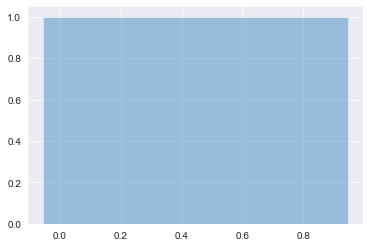

In [84]:
sns.distplot(samples[:,0])

In [100]:
def unpack_batch_a2c(batch, net, last_val_gamma, device="cpu"):
    """
    Convert batch into training tensors
    :param batch:
    :param net:
    :return: states variable, actions tensor, reference values variable
    """
    states = []
    actions = []
    rewards = []
    not_done_idx = []
    last_states = []
    
    for idx, exp in enumerate(batch):
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        if exp.last_state is not None:
            not_done_idx.append(idx)
            last_states.append(exp.last_state)
    
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = torch.FloatTensor(actions).to(device)

    # handle rewards
    rewards_np = np.array(rewards, dtype=np.float32)
    if not_done_idx:
        last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
        last_vals_v = net(last_states_v)[2]
        last_vals_np = last_vals_v.data.cpu().numpy()[:, 0]
        rewards_np[not_done_idx] += last_val_gamma * last_vals_np

    ref_vals_v = torch.FloatTensor(rewards_np).to(device)
    return states_v, actions_v, ref_vals_v

In [173]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = OrbitalDynamicsEnv(dt_s = 3.0, verbose=True, target_alt = 1.75, record_history = False)
test_env = OrbitalDynamicsEnv(dt_s = 3.0, verbose=True, target_alt = 1.75, record_rate = 1)

net = ModelA2C(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
up_net = TestNet(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
print(net)

agent = AgentA2C(net, device=device)

Units
-----
	time: 1 s =  0.0012414853327976582  tn
	length: 1 m =  1.5696123057604772e-07  ln
Simulation parameters
-----
	natural units time step size:  0.003724455998392975
	target theta dot:  0.4319593977248311  1/tn
	max allowable natural time:  21.81866631542346  tn =  17574.646867760897  s
	max allowed steps:  5859
Policy Parameters
-----
	Discrete thrust acceleration:  1.5  ln/tn^2 =  14.729298049223939  m/s^2
Units
-----
	time: 1 s =  0.0012414853327976582  tn
	length: 1 m =  1.5696123057604772e-07  ln
Simulation parameters
-----
	natural units time step size:  0.003724455998392975
	target theta dot:  0.4319593977248311  1/tn
	max allowable natural time:  21.81866631542346  tn =  17574.646867760897  s
	max allowed steps:  5859
Policy Parameters
-----
	Discrete thrust acceleration:  1.5  ln/tn^2 =  14.729298049223939  m/s^2
ModelA2C(
  (base): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
  )
  (mu): Sequential(
    (0): Linear(in_featu

C:\Users\BVPHD\.conda\envs\py_torch\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Test Net Is Neutral (near zero means, near zero variances)

In [174]:
s = env.reset()
s_v = torch.FloatTensor([s]).to(device)
net(s_v)

(tensor([[ 0.2001, -0.2154]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[0.2047, 0.2450]], device='cuda:0', grad_fn=<AbsBackward>),
 tensor([[0.2900]], device='cuda:0', grad_fn=<AddmmBackward>))

In [175]:
agent(s,None) # s needs to be numpy array

(array([ 0.26140684, -0.4830613 ]), None)

In [176]:
up_net(s_v)

(tensor([[1.1000, 0.0000]]),
 tensor([[0.0010, 0.0010]]),
 tensor([[0.0794]], device='cuda:0', grad_fn=<AddmmBackward>))

### Pretrain so that we have good initial settings (the mentor)

In [177]:
net = ModelA2C(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)

go_thrust_v = torch.FloatTensor([[env.max_thrust*0.9, 0.0]]).to(device)

# this pumps the variance parameters so we start off with high exploration
for _ in range(10):
    optimizer.zero_grad()
    
    mu_v, var_v, value_v = net(s_v)
    ent_v = -(torch.log(2*np.pi*var_v) + 1)/2
    entropy_loss_v =  0.001*ent_v.mean()
    mu_loss_v = ((mu_v - go_thrust_v)**2).mean()
    
    loss_v = mu_loss_v + entropy_loss_v
    
    loss_v.backward()
    optimizer.step()

In [145]:
net(s_v) # mean near (max_thrust,0) large variances for exploration

(tensor([[ 1.1963, -0.0244]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[2.2601, 1.8347]], device='cuda:0', grad_fn=<AbsBackward>),
 tensor([[0.0322]], device='cuda:0', grad_fn=<AddmmBackward>))

In [185]:
GAMMA = 0.999
REWARD_STEPS = 3
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
ENTROPY_BETA = 1e-6

TEST_ITERS = 5000

exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, GAMMA, 
                                                       steps_count=REWARD_STEPS)

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

batch = []
best_reward = None

#reward_100 = collections.deque(maxlen=100)
    
for step_idx, exp in enumerate(exp_source):
    rewards_steps = exp_source.pop_rewards_steps()
    if rewards_steps:
        rewards, steps = zip(*rewards_steps)
        #reward_100.append(rewards[0])

    if step_idx % TEST_ITERS == 0:
        ts = time.time()
        rewards, steps = test_net(net, test_env, device=device)
        print("Test done is %.2f sec, reward %.3f, steps %d" %\
              (time.time() - ts, rewards, steps))
        #writer.add_scalar("test_reward", rewards, step_idx)
        #writer.add_scalar("test_steps", steps, step_idx)
        if (best_reward is None) or (best_reward < rewards):
            if best_reward is not None:
                print("Best reward updated: %.8f -> %.8f" % (best_reward, rewards))
            best_reward = rewards

    batch.append(exp)
    if len(batch) < BATCH_SIZE:
        continue

    states_v, actions_v, vals_ref_v = unpack_batch_a2c(batch, net, device=device,
                                                       last_val_gamma=GAMMA**REWARD_STEPS)
    batch.clear()

    optimizer.zero_grad()
    
    mu_v, var_v, value_v = net(states_v)
    loss_value_v = F.mse_loss(value_v.squeeze(-1), vals_ref_v)

    adv_v = vals_ref_v.unsqueeze(dim=-1) - value_v.detach()
    log_prob_v = adv_v * calc_logprob(mu_v, var_v, actions_v)
    loss_policy_v = -log_prob_v.mean()
    ent_v = -(torch.log(2*np.pi*var_v) + 1)/2
    entropy_loss_v = ENTROPY_BETA * ent_v.mean()

    loss_v = loss_policy_v + entropy_loss_v + loss_value_v
    loss_v.backward()
    optimizer.step()

Test done is 2.95 sec, reward 449.214, steps 456
Test done is 2.85 sec, reward -9602.073, steps 457
Test done is 2.92 sec, reward 315.553, steps 457
Test done is 2.76 sec, reward -6527.606, steps 457
Test done is 2.88 sec, reward 404.359, steps 457
Test done is 2.85 sec, reward 450.004, steps 457
Best reward updated: 449.21404356 -> 450.00429071
Test done is 2.80 sec, reward 438.643, steps 458
Test done is 2.89 sec, reward 427.175, steps 458
Test done is 2.82 sec, reward 424.445, steps 458
Test done is 2.92 sec, reward 446.524, steps 459
Test done is 2.82 sec, reward 451.689, steps 459
Best reward updated: 450.00429071 -> 451.68863444
Test done is 2.91 sec, reward 390.442, steps 460
Test done is 2.90 sec, reward 442.817, steps 460
Test done is 2.79 sec, reward 452.108, steps 460
Best reward updated: 451.68863444 -> 452.10766193
Test done is 2.90 sec, reward 452.557, steps 460
Best reward updated: 452.10766193 -> 452.55745356
Test done is 2.81 sec, reward 452.326, steps 460
Test done is

KeyboardInterrupt: 

In [186]:
states_v

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.000

In [187]:
actions_v

tensor([[ 0.2303,  0.1773],
        [-0.1050, -0.6177],
        [-0.3518, -0.5366],
        [ 0.2080,  0.1993],
        [-0.2473, -1.5245],
        [-0.1059,  0.5929],
        [ 0.5547, -0.4433],
        [ 0.9824, -0.4467],
        [ 0.1581, -0.1858],
        [ 0.5029,  0.1782],
        [ 0.2030, -0.5476],
        [ 0.8845, -0.2801],
        [ 0.4903, -1.0380],
        [-0.6008, -0.7062],
        [-0.3537,  0.0331],
        [-0.1133,  0.1747],
        [ 0.3445, -0.4277],
        [ 0.1424,  0.3348],
        [-0.5533,  0.1086],
        [ 0.4033,  0.4684],
        [ 0.5011,  0.0674],
        [ 0.1518, -0.4384],
        [ 1.0142, -0.7910],
        [-0.5758, -0.5316],
        [-0.1780, -0.3911],
        [-0.2289, -0.5581],
        [ 0.5057, -0.0875],
        [ 0.7676, -0.1904],
        [ 0.7590,  0.5906],
        [-0.0505, -0.0583],
        [ 0.2575, -1.3148],
        [ 0.0963, -0.7912],
        [ 0.0643, -0.2275],
        [-0.1130, -0.1836],
        [ 0.7432, -0.3411],
        [ 0.8766,  0

In [188]:
vals_ref_v

tensor([0.9855, 0.9857, 0.9857, 0.9856, 0.9856, 0.9857, 0.9853, 0.9850, 0.9856,
        0.9854, 0.9855, 0.9851, 0.9853, 0.9856, 0.9857, 0.9857, 0.9854, 0.9856,
        0.9857, 0.9854, 0.9854, 0.9856, 1.9696, 0.9857, 0.9857, 0.9857, 0.9854,
        0.9852, 0.9851, 0.9857, 0.9854, 0.9856, 0.9856, 0.9857, 0.9852, 0.9851,
        0.9855, 0.9855, 0.9856, 0.9856, 0.9853, 0.9854, 0.9855, 0.9853, 0.9854,
        0.9857, 0.9856, 0.9857, 0.9850, 0.9857, 0.9853, 0.9857, 0.9854, 0.9857,
        0.9857, 1.9695, 0.9854, 0.9857, 0.9852, 0.9855, 0.9857, 0.9857, 0.9853,
        0.9857], device='cuda:0')

In [189]:
s = env.reset()
s_v = torch.FloatTensor([s]).to(device)
net(s_v)

(tensor([[ 6.5464, -0.4173]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[0.0378, 0.1317]], device='cuda:0', grad_fn=<AbsBackward>),
 tensor([[1.0399]], device='cuda:0', grad_fn=<AddmmBackward>))

In [192]:
test_net(net, test_env, count=1, device=device)
#test_net(up_net, test_env, count=1)

(450.82352537520273, 458.0)

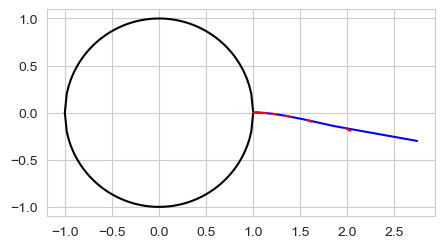

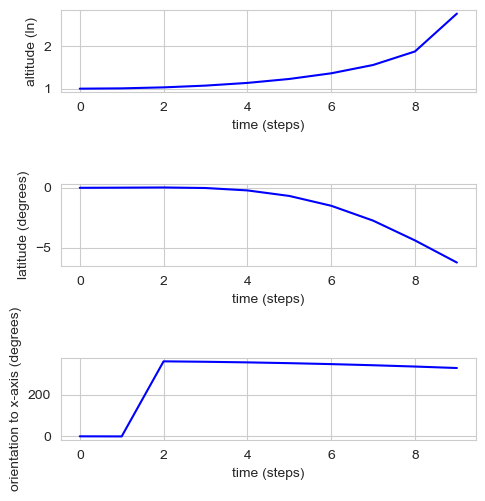

In [193]:
sns.set_style('whitegrid')
test_env.render(sample_traj_rate=50)

## Vanilla Policy Gradient Method

In [177]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using device: ',device)

HIDDEN_SIZE = 128

class PGN(nn.Module):
    def __init__(self, in_size):
        super(PGN,self).__init__()
        
        self.actions_mu = nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 2)
        )
    
        self.actions_var = nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 2)
        )
        
        self.values =  nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )
    
    def __call__(self, x):
        return self.actions_mu(x), self.actions_var(x), self.values(x)
    
policy_net = PGN(4).to(device)

policy_net

using device:  cpu


PGN(
  (actions_mu): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (actions_var): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (values): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [149]:
ridx = np.random.choice(range(len(traj_s)),size = 1000)
states_v = torch.FloatTensor(np.array(traj_s)[ridx])
actions_v = torch.LongTensor(np.array(traj_a)[ridx])
#actions_v = torch.eye(4)[traj_a]

In [178]:
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

In [152]:
for e in range(5000):
    optimizer.zero_grad()
    mu_v, var_v, _ = policy_net(states_v)
    
    loss_v = ((mu_v - actions_v)**2).mean()
    loss_v.backward()
    optimizer.step()
    
    if e % 100 == 0:
        print(loss_v.item())

0.611042857170105
0.07870986312627792
0.04247419536113739
0.029623961076140404
0.0246701892465353
0.022615090012550354
0.021483683958649635
0.020682865753769875
0.01997537910938263
0.019331539049744606
0.01875515654683113
0.018252111971378326
0.017818685621023178
0.01744617521762848
0.01712161675095558
0.016824597492814064
0.01656264252960682
0.01633056439459324
0.016125833615660667
0.015943657606840134
0.015776731073856354
0.015621383674442768
0.015472836792469025
0.015327652916312218
0.01518517266958952
0.015045098960399628
0.01490660198032856
0.01477011013776064
0.014637439511716366
0.014506872743368149
0.014379916712641716
0.014262971468269825
0.014149095863103867
0.014043898321688175
0.013938740827143192
0.01384030096232891
0.013742691837251186
0.013647002167999744
0.013478003442287445
0.013384887017309666
0.013283448293805122
0.013193108141422272
0.013111486099660397
0.01303156465291977
0.012958995997905731
0.012887602671980858
0.012806102633476257
0.012738815508782864
0.01267056

In [162]:
state = env.reset()
episode_R = 0.0

while True:
    state_v = torch.FloatTensor([state])
    mu_v, var_v, _ = policy_net(state_v)
    mu = mu_v.data.cpu().numpy()[0]
    
    state, reward, is_done, _ = env.step(mu)
    episode_R += reward
    if is_done:
        break

In [163]:
episode_R

-631.6050344747143

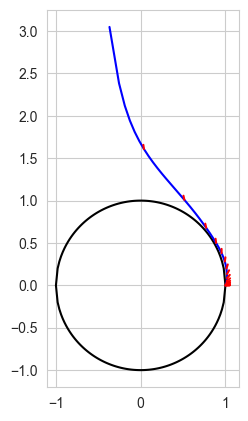

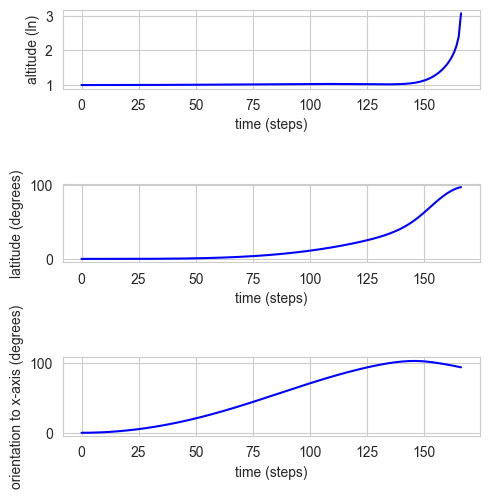

In [164]:
sns.set_style('whitegrid')
env.render()

In [171]:
def calc_logprob(mu_v, var_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * np.pi * var_v))
    return p1 + p2

tensor([[-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209]], grad_fn=<AddBackward0>)


RuntimeError: The size of tensor a (10) must match the size of tensor b (2) at non-singleton dimension 1

-1572.8280186113989 4055.6625553967274


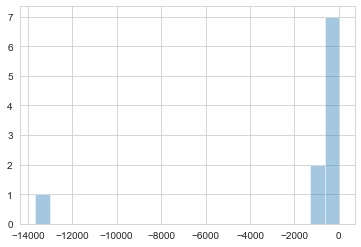

In [174]:
print(np.mean(total_rewards), np.std(total_rewards))
sns.distplot(total_rewards,kde=False);

Episode Reward:  -1105.2090478697733


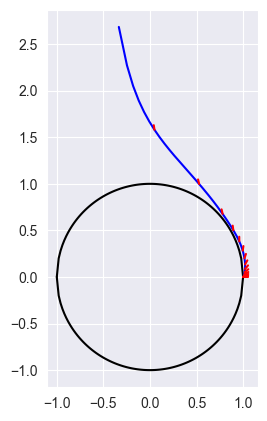

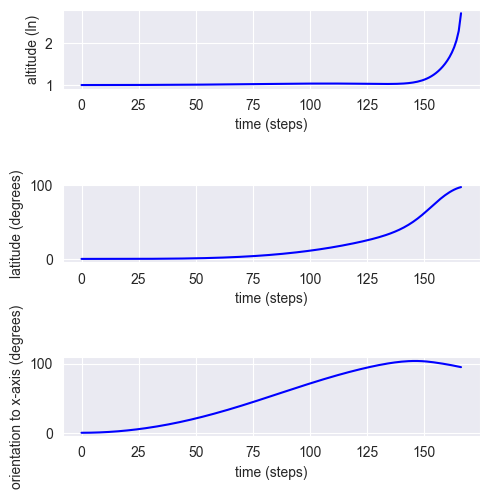

In [176]:
s = env.reset()

episode_reward = 0.0

program_cmd_history = []

done = False
while not done:
    s_v = torch.FloatTensor(s).unsqueeze(0).to(device)
    mu_v, var_v, _ = policy_net(s_v)
    mu = mu_v.data.cpu().numpy()
    var = var_v.data.cpu().numpy()
    a = [np.random.normal(loc=mu[0,0],scale=np.abs(var[0,0])),
         np.random.normal(loc=mu[0,1],scale=np.abs(var[0,1]))]

    program_cmd_history.append(a)    
    s, r, done,_ = env.step(a)
    episode_reward +=r

print('Episode Reward: ', episode_reward)
sns.set_style('darkgrid')
env.render()

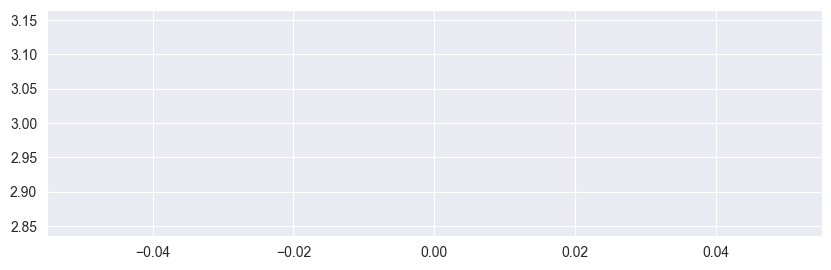

In [95]:
plt.figure(figsize=(10,3), dpi=100)
plt.plot(program_cmd_history);